In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import streamlit as st
from flask import Flask, request, jsonify

In [3]:
# Load dataset
data = pd.read_csv("customer_churn.csv")

In [5]:
# Display basic info
print(data.head())
print(data.info())

   CustomerID  Tenure  MonthlyCharges  TotalCharges        Contract  \
0           1      52          105.57       3271.81        One year   
1           2      15          103.02       6420.56  Month-to-month   
2           3      61           59.72       1711.88        One year   
3           4      21           86.81       4485.17        Two year   
4           5      24           40.50       5891.26        One year   

   PaymentMethod  Churn  
0    Credit card      0  
1    Credit card      1  
2   Mailed check      0  
3    Credit card      1  
4  Bank transfer      0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      1000 non-null   int64  
 1   Tenure          1000 non-null   int64  
 2   MonthlyCharges  1000 non-null   float64
 3   TotalCharges    1000 non-null   float64
 4   Contract        1000 non-null   objec

In [7]:
# Handling missing values
data = data.dropna()


In [9]:
# Encode categorical variables
le = LabelEncoder()
for col in data.select_dtypes(include=['object']).columns:
    data[col] = le.fit_transform(data[col])

In [11]:
# Splitting features and target
X = data.drop("Churn", axis=1)
y = data["Churn"]

In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
# Hyperparameter Tuning
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None]
}
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 20, None],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [19]:
# Train Multiple Models
rf_model = grid_search_rf.best_estimator_
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train, y_train)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

E:\Downloads\anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:55:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [21]:
# Save models
joblib.dump(rf_model, "rf_model.pkl")
joblib.dump(svm_model, "svm_model.pkl")
joblib.dump(xgb_model, "xgb_model.pkl")

['xgb_model.pkl']

In [23]:
# Model Evaluation
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy:", accuracy)
    print(f"{name} Classification Report:\n", classification_report(y_test, y_pred))
    print(f"{name} Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

evaluate_model(rf_model, X_test, y_test, "Random Forest")
evaluate_model(svm_model, X_test, y_test, "SVM")
evaluate_model(xgb_model, X_test, y_test, "XGBoost")

Random Forest Accuracy: 0.775
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.97      0.87       158
           1       0.29      0.05      0.08        42

    accuracy                           0.78       200
   macro avg       0.54      0.51      0.48       200
weighted avg       0.69      0.78      0.71       200

Random Forest Confusion Matrix:
 [[153   5]
 [ 40   2]]
SVM Accuracy: 0.79
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88       158
           1       0.00      0.00      0.00        42

    accuracy                           0.79       200
   macro avg       0.40      0.50      0.44       200
weighted avg       0.62      0.79      0.70       200

SVM Confusion Matrix:
 [[158   0]
 [ 42   0]]
XGBoost Accuracy: 0.69
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       

E:\Downloads\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Downloads\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
E:\Downloads\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


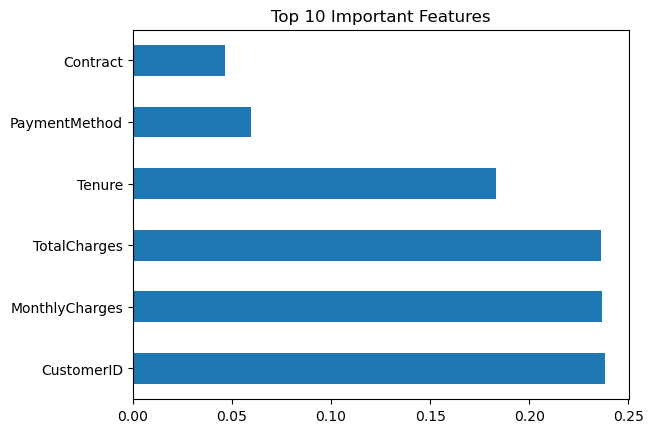

In [25]:
# Feature Importance
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.show()